In [1]:
# 라이브러리 설치 및 임포트
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

### ModelCheckpoint 사용하면 코랩에서 에러 발생
- history = train_model(model, train_dataset, val_dataset, EPOCHS, LEARNING_RATE, SAVE_PATH) 호출 될 때 optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 에러가 남

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-28-cda70b969c54> in <cell line: 14>()
     12 
     13 # # 학습 및 체크포인트 저장
---> 14 history = train_model(model, train_dataset, val_dataset, EPOCHS, LEARNING_RATE, SAVE_PATH)
     15 
     16 # 손실 시각화

3 frames
/usr/local/lib/python3.10/dist-packages/tf_keras/src/optimizers/__init__.py in get(identifier, **kwargs)
    333         )
    334     else:
--> 335         raise ValueError(
    336             f"Could not interpret optimizer identifier: {identifier}"
    337         )

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7fa5c55342b0>
```

#### 위 문제 디버깅 시 참고
https://discuss.huggingface.co/t/pretrain-model-not-accepting-optimizer/76209/27

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 경고 메시지 억제

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# 설정
FILE_PATH = "concat_train_test.csv"
TEST_FILE_PATH = "test_cleansed_241208.csv"
SAVE_PATH = "best_koelectra_model_weights_2412091250.h5"
FINAL_SAVE_PATH = "final_koelectra_model_2412091250"
OUTPUT_FILE = "submission_koelectra_2412091250.csv"
OUTPUT_CSV_FILE ="test_with_predictions_koelectra_2412091250.csv"
PRETRAINED_MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 5e-5

In [5]:
# 클래스 매핑 정의
class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

# class_mapping에서 클래스 이름 리스트 생성
class_labels = [k for k, v in sorted(class_mapping.items(), key=lambda item: item[1])]

# 클래스 수 계산
num_classes = len(class_mapping)

print("Class Labels:", class_labels)
print("Number of Classes:", num_classes)

Class Labels: ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
Number of Classes: 5


In [6]:
def load_data(file_path, text_column='conversation', label_column='class'):
    """
    CSV 파일에서 데이터를 로드하고 텍스트와 레이블을 반환하며, 레이블을 숫자로 매핑합니다.
    Args:
    - file_path (str): 데이터 파일 경로
    - text_column (str): 텍스트가 저장된 열 이름 (기본값: 'conversation')
    - label_column (str): 레이블이 저장된 열 이름 (기본값: 'class')
    Returns:
    - texts (list of str): 입력 텍스트 리스트
    - labels (list of str): 클래스 레이블 리스트
    - mapped_labels (list of int): 숫자로 매핑된 클래스 레이블 리스트
    """
    # 데이터 로드
    data = pd.read_csv(file_path)

    # NaN 값 제거
    data = data.dropna(subset=[text_column, label_column])

    # 텍스트와 레이블 열 추출
    texts = data[text_column].tolist()
    labels = data[label_column].tolist()

    # 레이블을 숫자로 매핑
    mapped_labels = [class_mapping[label] for label in labels]

    # 텍스트 데이터와 레이블 정리
    cleaned_data = [
        (text, label, mapped_label) 
        for text, label, mapped_label in zip(texts, labels, mapped_labels)
        if isinstance(text, str) and text.strip()  # 문자열이 아니거나 빈 텍스트 제거
    ]
    texts, labels, mapped_labels = zip(*cleaned_data)

    return list(texts), list(labels), list(mapped_labels)

In [7]:
import math

# dataset 확인용 test 코드
file_path = FILE_PATH
texts, labels, mapped_labels = load_data(file_path)

# 숫자 -> 클래스 이름 디코딩
decoded_labels = [class_labels[label] for label in mapped_labels]

# 각 클래스별 갯수 계산
class_counts = Counter(labels)

# 출력
print("Mapped Labels:", mapped_labels[:5])
print("Class Names:", decoded_labels[:5])
print("Class Counts:", dict(class_counts))

print(type(texts))
print(any(text == "" for text in texts))  # 빈 문자열 확인
print(any(text is None for text in texts))  # None 값 확인

# NaN 확인
contains_nan = any(isinstance(text, float) and math.isnan(text) for text in texts)
print("NaN 포함 여부:", contains_nan)

# NaN 값 위치 출력
nan_indices = [i for i, text in enumerate(texts) if isinstance(text, float) and math.isnan(text)]
print("NaN 값 위치:", nan_indices)

print(type(mapped_labels))
print(all(isinstance(label, int) for label in mapped_labels))  # 모든 레이블이 int인지 확인

# 텍스트 길이 분석
text_lengths = [len(text) for text in texts if isinstance(text, str)]  # 문자열 길이 계산
max_length_text = max(text_lengths)  # 최대 길이
min_length_text = min(text_lengths)  # 최소 길이
mean_length = np.mean(text_lengths)  # 평균 길이
std_dev_length = np.std(text_lengths)  # 표준편차
max_length = int(mean_length + 2 * std_dev_length)  # max_length 계산
MAX_LENGTH = max_length

# max_length 이내에 포함되는 데이터 비율 계산
within_max_length = sum(length <= max_length for length in text_lengths)
total_texts = len(text_lengths)
percentage_within_max_length = (within_max_length / total_texts) * 100

# 출력
print("\n--- 텍스트 길이 분석 ---")
print(f"최대 길이: {max_length_text}")
print(f"최소 길이: {min_length_text}")
print(f"평균 길이: {mean_length:.2f}")
print(f"표준편차: {std_dev_length:.2f}")
print(f"max_length (평균 + 2 * 표준편차): {MAX_LENGTH}")
print(f"max_length 이내 데이터 비율: {percentage_within_max_length:.2f}% ({within_max_length}/{total_texts})")

Mapped Labels: [0, 0, 3, 1, 1]
Class Names: ['협박 대화', '협박 대화', '기타 괴롭힘 대화', '갈취 대화', '갈취 대화']
Class Counts: {'협박 대화': 896, '기타 괴롭힘 대화': 1094, '갈취 대화': 981, '직장 내 괴롭힘 대화': 979, '일반 대화': 390}
<class 'list'>
False
False
NaN 포함 여부: False
NaN 값 위치: []
<class 'list'>
True

--- 텍스트 길이 분석 ---
최대 길이: 874
최소 길이: 41
평균 길이: 220.18
표준편차: 102.06
max_length (평균 + 2 * 표준편차): 424
max_length 이내 데이터 비율: 95.55% (4147/4340)


In [8]:
# 데이터 준비 함수 정의
def prepare_data(texts, mapped_labels, tokenizer, max_length, batch_size):
    """
    데이터를 전처리하여 TensorFlow Dataset으로 변환합니다.
    Args:
    - texts (list of str): 입력 텍스트
    - mapped_labels (list): 숫자로 매핑된 클래스 레이블
    - tokenizer: Hugging Face Tokenizer
    - max_length (int): 토큰화된 입력의 최대 길이
    - batch_size (int): 배치 크기
    Returns:
    - train_dataset, val_dataset: 학습과 검증에 사용할 TensorFlow Dataset
    - val_texts, val_labels: 검증 데이터 (추가적인 분석을 위해 반환)
    """
    # 1. 데이터 나누기
    # train_test_split에서 stratify를 추가하여 클래스 비율이 학습 데이터와 검증 데이터에 동일하게 유지
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, mapped_labels, test_size=0.2, random_state=42, stratify=mapped_labels
    )
    
    print(f"Train texts: {len(train_texts)}, Val texts: {len(val_texts)}")
    
    def tokenize(texts, labels):
        """
        입력 텍스트를 토크나이즈하고 TensorFlow 텐서로 변환합니다.
        Args:
        - texts (list of str): 입력 텍스트 리스트
        - labels (list): 숫자 레이블 리스트
        Returns:
        - inputs (dict): 토크나이즈된 입력 데이터
        - labels_tensor (tf.Tensor): TensorFlow 형식의 레이블 데이터
        """
        inputs = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="tf"
        )
        labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)
        print(f"Tokenized input shapes: {inputs['input_ids'].shape}")
        return dict(inputs), labels_tensor

#     # 2. TensorFlow Dataset 생성
#     train_inputs, train_labels = tokenize(train_texts, train_labels)
#     val_inputs, val_labels = tokenize(val_texts, val_labels)

#     train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # 2. TensorFlow Dataset 생성
    train_inputs, train_labels = tokenize(train_texts, train_labels)
    val_inputs, val_labels = tokenize(val_texts, val_labels)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_inputs), train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_inputs), val_labels))

    # 배치 처리
    train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # 3. 데이터 반환
    return train_dataset, val_dataset, val_texts, val_labels

#### 분류 헤드 추가
1. TFBertForSequenceClassification 클래스:
 - Hugging Face에서 제공하는 KLUE-BERT 기반 분류 모델 클래스입니다.
 - 이 클래스는 [CLS] 토큰 출력 위에 분류를 수행하는 Dense 레이어가 이미 정의되어 있습니다.
 - num_labels 매개변수로 분류할 클래스의 개수를 지정합니다.

2. Dense 레이어 자동 추가:
 - KLUE-BERT의 [CLS] 토큰 출력은 모델의 첫 번째 토큰에 해당하는 벡터입니다.
 - TFBertForSequenceClassification은 이 [CLS] 토큰을 입력으로 받아, Dropout과 Dense 레이어를 통해 클래스 확률 분포를 출력합니다.
---
#### Dense 레이어의 동작
 - TFBertForSequenceClassification 내부 동작을 요약하면 다음과 같습니다:
1. KLUE-BERT 출력:
  - 입력 문장을 토큰화한 후 KLUE-BERT에 전달.
  - KLUE-BERT는 각 토큰에 대한 벡터 출력(문장 벡터 포함).
2. [CLS] 토큰 선택:
  - KLUE-BERT 출력의 첫 번째 벡터(문장 전체를 대표하는 [CLS] 토큰)를 선택.
3. Dense 레이어:
  - [CLS] 토큰에 Dropout을 적용한 후, 분류 작업을 위한 Dense 레이어를 추가.


In [9]:
# # 모델 구성 함수 정의s
def build_model(pretrained_model_name, num_labels, freeze_backbone=False):
    """
    KoELECTRA를 기반으로 분류 모델을 구성합니다.
    Args:
    - pretrained_model_name (str): 사전 학습 모델 이름
    - num_labels (int): 클래스 수
    - freeze_backbone (bool): ELECTRA 백본 레이어 프리징 여부
    Returns:
    - model: TensorFlow Keras 모델
    """
    # KoELECTRA 분류 모델 로드
    model = TFElectraForSequenceClassification.from_pretrained(
        pretrained_model_name,
        num_labels=num_labels,
        from_pt=True  # PyTorch에서 변환 여부
    )

    # ELECTRA 백본 레이어 프리징 (옵션)
    if freeze_backbone:
        # ELECTRA 레이어 프리징
        for layer in model.electra.encoder.layer:
            layer.trainable = False

    # 모델 출력 확인 (디버깅용)
    print(model.summary())

    return model

In [10]:
# 학습 함수 정의
def train_model(model, train_dataset, val_dataset, epochs, learning_rate, save_path, patience=5):
    """
    모델을 학습시키고 가장 좋은 모델을 저장합니다.
    Args:
    - model: TensorFlow Keras 모델
    - train_dataset: 학습 데이터셋
    - val_dataset: 검증 데이터셋
    - epochs (int): 학습 에폭 수
    - learning_rate (float): 학습률
    - save_path (str): 가장 좋은 모델을 저장할 경로
    - patience (int): 조기 종료를 위한 검증 손실 모니터링 에폭 수
    Returns:
    - history: 학습 기록
    """
    # 모델 컴파일
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = ["accuracy"]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # 체크포인트 콜백 정의
    checkpoint = ModelCheckpoint(
        filepath=save_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=1
    )

    # 조기 종료 콜백 추가
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        mode="min",
        verbose=1,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping]
    )

    return history

In [11]:
# 손실 시각화
def plot_loss(history):
    """
    학습 및 검증 손실을 시각화합니다.
    Args:
    - history: 모델 학습 기록
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
# F1 Score 계산
def calculate_f1_score(model, tokenizer, val_texts, val_labels, class_labels, max_length):
    """
    검증 데이터에 대해 F1 Score를 계산합니다.
    Args:
    - model: 학습된 모델
    - tokenizer: Hugging Face Tokenizer
    - val_texts: 검증 데이터 텍스트
    - val_labels: 검증 데이터 레이블
    - class_labels: 클래스 이름 리스트
    - max_length: 입력 텍스트의 최대 길이
    Returns:
    - y_true_classes: 실제 클래스 레이블
    - y_pred_classes: 예측된 클래스 레이블
    """
    # 검증 데이터 토크나이징
    inputs = tokenizer(
        val_texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # 예측
    predictions = model.predict(dict(inputs))
    predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

    # F1 Score 계산
    f1_weighted = f1_score(val_labels, predicted_classes, average="weighted")
    f1_per_class = f1_score(val_labels, predicted_classes, average=None)
    print(f"Weighted F1 Score: {f1_weighted}\n")

    # F1 Score per class 출력
    print("F1 Score per class:")
    for label, score in zip(class_labels, f1_per_class):
        print(f"{label}: {score:.4f}")

    # Classification Report 출력
    print("\nClassification Report:")
    print(classification_report(val_labels, predicted_classes, target_names=class_labels))

    return val_labels, predicted_classes

In [13]:
# 가장 좋은 모델 로드 함수 정의
def load_best_model(model, save_path):
    """
    저장된 가장 좋은 모델의 가중치를 로드합니다.
    Args:
    - model: 초기화된 모델
    - save_path (str): 저장된 체크포인트 파일 경로
    Returns:
    - model: 가중치를 로드한 모델
    """
    model.load_weights(save_path)
    print(f"Best model loaded from {save_path}")
    return model


In [14]:
# 모델 및 토크나이저 저장 함수 정의
def save_model_and_tokenizer(model, tokenizer, save_path):
    """
    모델과 토크나이저를 저장합니다.
    Args:
    - model: 학습된 모델
    - tokenizer: Hugging Face Tokenizer
    - save_path (str): 모델 저장 경로
    """
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model and tokenizer saved to {save_path}")


In [15]:
# 테스트 데이터 로드 함수 정의
def load_test_data(file_path):
    """
    테스트 데이터를 로드합니다.
    Args:
    - file_path (str): 테스트 데이터 파일 경로
    Returns:
    - df_test: pandas DataFrame (idx와 text 열 포함)
    """
    df_test = pd.read_csv(file_path)
    return df_test


In [16]:
# 테스트 데이터 예측 및 제출 파일 생성 함수 정의
def predict_and_create_submission(model, tokenizer, test_data, output_file, class_labels, max_length=128):
    """
    학습된 모델을 사용해 테스트 데이터를 예측하고, 캐글 제출용 CSV 파일 생성.
    Args:
    - model: 학습된 TensorFlow 모델
    - tokenizer: Hugging Face Tokenizer
    - test_data: pandas DataFrame (idx, text 열 포함)
    - output_file (str): 생성할 submission.csv 파일 경로
    - class_labels (list of str): 클래스 이름 리스트
    - max_length (int): 토큰화된 입력의 최대 길이
    Returns:
    - None (submission.csv 파일 생성)
    """
    # 입력 텍스트 추출
    texts = test_data['text'].tolist()

    # 데이터 토크나이징
    inputs = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # 모델 예측
    predictions = model.predict(dict(inputs))
    predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

    # 클래스 이름으로 변환 (필요 시 사용)
    predicted_labels = [class_labels[cls] for cls in predicted_classes]

    # 결과를 DataFrame으로 변환
    submission = pd.DataFrame({
        "idx": test_data['idx'],      # 파일 이름 또는 고유 식별자
        "target": predicted_classes   # 정수형 클래스 ID
    })

    # CSV 파일 저장
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved to {output_file}")

In [17]:
# 데이터 로드 및 전처리
texts, labels, mapped_labels = load_data(FILE_PATH)  # mapped_labels 포함
tokenizer = ElectraTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

# 데이터셋 생성
train_dataset, val_dataset, val_texts, val_labels = prepare_data(
    texts, mapped_labels, tokenizer, MAX_LENGTH, BATCH_SIZE
)

Train texts: 3472, Val texts: 868
Tokenized input shapes: (3472, 424)
Tokenized input shapes: (868, 424)


In [18]:
# 모델 생성
model = build_model(PRETRAINED_MODEL_NAME, num_labels=num_classes, freeze_backbone=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Model: "tf_electra_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
electra (TFElectraMainLayer) multiple                  112330752 
_________________________________________________________________
classifier (TFElectraClassif multiple                  594437    
Total params: 112,925,189
Trainable params: 27,870,725
Non-trainable params: 85,054,464
_________________________________________________________________
None


```
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```
#### 경고 원인
1. 모델 간의 아키텍처 차이:

- 예를 들어, **BertForPreTraining**과 **BertForSequenceClassification**은 다른 아키텍처를 가집니다.
- BertForPreTraining에는 다음과 같은 추가 가중치가 포함됩니다:
 - cls.predictions.*: 언어 모델링(MLM, Masked Language Modeling)용 레이어.
 - cls.seq_relationship.*: 문장 관계 예측(NSP, Next Sentence Prediction)용 레이어.
- TFBertModel은 기본적으로 Transformer Encoder만 포함하므로, 언어 모델링이나 문장 관계 예측을 위한 가중치는 사용되지 않습니다.  

2. PyTorch -> TensorFlow 변환:
- Hugging Face의 PyTorch 모델을 TensorFlow 모델로 변환할 때, 특정 가중치는 TensorFlow 모델의 요구사항에 맞지 않아 제외될 수 있습니다.
- 이는 변환 과정에서 자연스러운 현상이며, 모델의 주요 기능에는 영향을 미치지 않습니다.

In [19]:
# 모델 학습
history = train_model(model, train_dataset, val_dataset, EPOCHS, LEARNING_RATE, SAVE_PATH)

Epoch 1/200
217/217 [==============================] - 293s 1s/step - loss: 1.5529 - accuracy: 0.2595 - val_loss: 1.5339 - val_accuracy: 0.2615

Epoch 00001: val_loss improved from inf to 1.53389, saving model to best_koelectra_model_weights_2412081250.h5
Epoch 2/200
217/217 [==============================] - 282s 1s/step - loss: 1.4930 - accuracy: 0.3174 - val_loss: 1.4416 - val_accuracy: 0.3664

Epoch 00002: val_loss improved from 1.53389 to 1.44158, saving model to best_koelectra_model_weights_2412081250.h5
Epoch 3/200
217/217 [==============================] - 282s 1s/step - loss: 1.2765 - accuracy: 0.4680 - val_loss: 1.1496 - val_accuracy: 0.5150

Epoch 00003: val_loss improved from 1.44158 to 1.14959, saving model to best_koelectra_model_weights_2412081250.h5
Epoch 4/200
217/217 [==============================] - 282s 1s/step - loss: 1.0016 - accuracy: 0.5691 - val_loss: 0.9798 - val_accuracy: 0.5887

Epoch 00004: val_loss improved from 1.14959 to 0.97978, saving model to best_ko

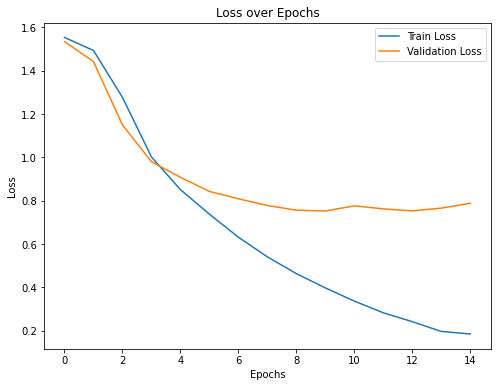

In [20]:
# 학습 손실 시각화
if 'loss' in history.history and 'val_loss' in history.history:
    plot_loss(history)

In [21]:
# 가장 좋은 모델 로드
model.load_weights(SAVE_PATH)
print("Best model weights loaded.")

# 모델 및 토크나이저 저장
model.save_pretrained(FINAL_SAVE_PATH)
tokenizer.save_pretrained(FINAL_SAVE_PATH)
print(f"Model and tokenizer saved to {FINAL_SAVE_PATH}")

Best model weights loaded.
Model and tokenizer saved to final_koelectra_model_2412081250


In [22]:
# F1 Score 계산 및 예측 값 반환
y_true_classes, y_pred_classes = calculate_f1_score(model, tokenizer, val_texts, val_labels, class_labels, MAX_LENGTH)

Weighted F1 Score: 0.7326241463587106

F1 Score per class:
협박 대화: 0.7480
갈취 대화: 0.6935
직장 내 괴롭힘 대화: 0.8535
기타 괴롭힘 대화: 0.6020
일반 대화: 0.8588

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.71      0.79      0.75       179
       갈취 대화       0.68      0.70      0.69       196
 직장 내 괴롭힘 대화       0.86      0.85      0.85       196
   기타 괴롭힘 대화       0.66      0.55      0.60       219
       일반 대화       0.79      0.94      0.86        78

    accuracy                           0.74       868
   macro avg       0.74      0.77      0.75       868
weighted avg       0.73      0.74      0.73       868



In [23]:
# import matplotlib.font_manager as fm

# # 설치된 글꼴 목록 출력
# for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
#     print(fm.FontProperties(fname=font).get_name())

In [24]:
import matplotlib.font_manager as fm

# 한글 글꼴 설정
# plt.rcParams['font.family'] = 'AppleGothic'  # MacOS
plt.rcParams['font.family'] = 'NanumGothic'  # Linux
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

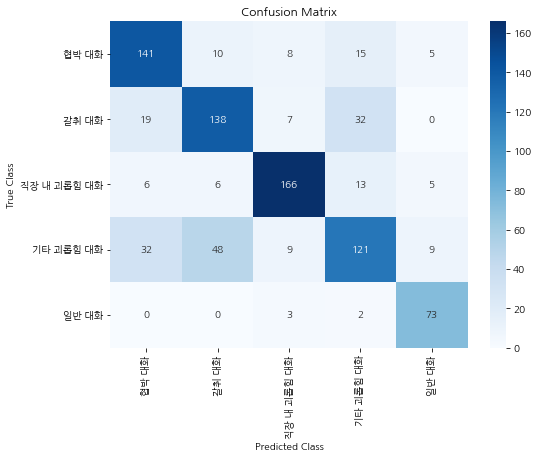

In [25]:
# Confusion Matrix 계산
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=range(len(class_labels)))

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# 테스트 데이터 로드
df_test = pd.read_csv(TEST_FILE_PATH)

# 테스트 데이터 예측 및 제출 파일 생성
predict_and_create_submission(
    model=model,
    tokenizer=tokenizer,
    test_data=df_test,
    output_file=OUTPUT_FILE,
    class_labels=class_labels,
    max_length=MAX_LENGTH
)

Submission file saved to submission_koelectra_2412081250.csv


In [27]:
# 간이 테스트 함수
def predict_class(model, tokenizer, texts, class_labels=None, max_length=128):
    """
    분류 모델을 사용해 입력 텍스트의 클래스를 예측합니다.
    
    Args:
    - model: 학습된 TensorFlow 분류 모델.
    - tokenizer: Hugging Face 토크나이저.
    - texts (list of str): 예측할 문장 리스트.
    - class_labels (list of str, optional): 클래스 이름 리스트. None이면 이름은 None 반환.
    - max_length (int): 토큰화된 입력의 최대 길이. 기본값 128.
    
    Returns:
    - list of tuple: 각 입력 문장에 대해 (클래스 인덱스, 클래스 이름) 튜플 리스트.
    """
    # 텍스트를 토크나이징
    inputs = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # 모델 예측
    predictions = model.predict(dict(inputs))
    predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

    # 클래스 이름 반환 여부
    results = []
    for cls in predicted_classes:
        cls_name = class_labels[cls] if class_labels else None
        results.append((cls, cls_name))

    return results

In [28]:
# 테스트 데이터
test_texts = [
    "아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네",
    "우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.",
    "너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요",
    "이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래",
    "아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도 말해야지? .켰습니다. 주인님. 오냐. 앞으로도 잘부탁한다 와이파이. 넵. 이렇게만 해? 알겠지? 응."
]

# 모델을 사용해 예측
predictions = predict_class(model, tokenizer, test_texts, class_labels=class_labels, max_length=MAX_LENGTH)

# 결과 출력
for idx, (text, (cls_index, cls_name)) in enumerate(zip(test_texts, predictions)):
    print(f"[{idx+1}] Text: {text}")
    print(f"    → Predicted Class Index: {cls_index}")
    print(f"    → Predicted Class Name: {cls_name}\n")

[1] Text: 아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네
    → Predicted Class Index: 3
    → Predicted Class Name: 기타 괴롭힘 대화

[2] Text: 우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.
    → Predicted Class Index: 2
    → Predicted Class Name: 직장 내 괴롭힘 대화

[3] Text: 너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요
    → Predicted Class Index: 2
    → Predicted Class Name: 직장 내 괴롭힘 대화

[4] Text: 이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래
    → Predicted Class Index

In [29]:
def process_and_save_predictions(model, tokenizer, input_file, output_file, class_labels, max_length=128):
    """
    테스트 데이터를 예측하고 클래스 이름을 추가한 뒤 저장합니다.

    Args:
    - model: 학습된 TensorFlow 분류 모델.
    - tokenizer: Hugging Face 토크나이저.
    - input_file (str): 입력 CSV 파일 경로 (test.csv).
    - output_file (str): 예측 결과를 저장할 CSV 파일 경로.
    - class_labels (list of str): 클래스 이름 리스트.
    - max_length (int): 토큰화된 입력의 최대 길이. 기본값 128.
    """
    # 테스트 데이터 읽기
    try:
        test_data = pd.read_csv(input_file)
    except Exception as e:
        print(f"Error reading input file: {e}")
        return

    # 입력 데이터 확인
    if 'text' not in test_data.columns:
        print("Error: The input file must contain a 'text' column.")
        return
    
    # 예측할 텍스트 열 추출
    texts = test_data['text'].tolist()

    # 클래스 예측
    predictions = predict_class(model, tokenizer, texts, class_labels, max_length)

    # 예측 결과를 데이터프레임에 추가
    test_data['predicted_class_index'] = [pred[0] for pred in predictions]  # 클래스 인덱스
    test_data['predicted_class_name'] = [pred[1] for pred in predictions]  # 클래스 이름

    # 클래스별 추론 갯수 계산 및 출력
    class_counts = Counter(test_data['predicted_class_name'])
    print("\nClass Prediction Counts:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    # 결과 저장
    try:
        test_data.to_csv(output_file, index=False)
        print(f"\nPredictions saved to {output_file}")
    except Exception as e:
        print(f"Error saving output file: {e}")

In [30]:
process_and_save_predictions(
    model=model,  # 학습된 모델
    tokenizer=tokenizer,  # Hugging Face 토크나이저
    input_file=TEST_FILE_PATH,  # 입력 파일 경로
    output_file=OUTPUT_CSV_FILE,  # 저장할 출력 파일 경로
    class_labels=class_labels,  # 클래스 이름
    max_length=128  # 최대 길이
)


Class Prediction Counts:
기타 괴롭힘 대화: 110
직장 내 괴롭힘 대화: 111
일반 대화: 99
협박 대화: 87
갈취 대화: 93

Predictions saved to test_with_predictions_koelectra_2412081250.csv
